# Instructions for Using the STAC API Extensions: query with one operator, sort, fields

This notebook provides a step-by-step guide on how to use the STAC (SpatioTemporal Asset Catalog) API to search for Sentinel-2 Level 2A data within a specified time range and geographic area. It demonstrates how to leverage STAC extensions for filtering, selecting, and sorting data based on specific parameters.

In the presented example, we will choose Prague, the capital of the Czech Republic, as the study area, focusing on the period from June to September 2020, in order to illustrate satellite imagery where the cloud cover is less than 20%.

In this case, we will show how to use the `query` extension to construct the appropriate parameter.

## Libraries

First, ensure all required packages are installed and imported.

In [1]:
!pip install stackstac && pip install pystac_client && pip install geogif
import pystac_client
import geogif
import stackstac
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.0.0
    Uninstalling pillow-11.0.0:
      Successfully uninstalled pillow-11.0.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


* `pystac_client`, `stackstack`: A Python library for working with STAC catalogs. It enables interaction with STAC services, reading catalog information, and searching for products based on specified parameters.
* `geogif`: A Python library for creating animated GIFs from data cubes, enabling the visualization of time series data in a dynamic and engaging format.
* `os`: A standard Python package that provides functionality for interacting with the operating system, including accessing environment variables and managing file paths. It is often used for authentication and setting up access credentials for various APIs and services, such as STAC.

## S3 Credentials

In order to access the data from CloudFerro's catalog, authentication is required. To facilitate this, you will need to create an account in the Copernicus Data Space Ecosystem (CDSE). The registration process is quick and can be completed in under 60 seconds. You can find the registration link here: https://documentation.dataspace.copernicus.eu/APIs/S3.html.

Once you have created an account, the same URL will redirect you to the section where you can generate your `S3 Credentials`. To do this, simply click the `Add Credential` button. This will allow you to define an expiration date for your credentials.

After selecting the expiration date, you will have successfully created your own S3 credentials. Please make sure to save the secret key at this point, as it will not be displayed again.

Now that you have your S3 credentials, you can use them to connect to the STAC catalog. By utilizing the `os` package, you will set environment variables to authenticate yourself as a valid user for the S3 protocol.

The only variables you need to configure are:
* `AWS_ACCESS_KEY_ID`
* `AWS_SECRET_ACCESS_KEY`.

In [5]:
os.environ['GDAL_HTTP_TCP_KEEPALIVE'] = "YES"
os.environ['AWS_S3_ENDPOINT'] = "eodata.dataspace.copernicus.eu"
os.environ['AWS_ACCESS_KEY_ID'] = "your_access_key" # !
os.environ['AWS_SECRET_ACCESS_KEY'] = "your_secret_access_key" # !
os.environ['AWS_HTTPS'] = "YES"
os.environ['AWS_VIRTUAL_HOSTING'] = "FALSE"
os.environ['GDAL_HTTP_UNSAFESSL'] = "YES"

## Connecting to the STAC Catalog

We connect to the Copernicus STAC catalog, available at the endpoint: https://stac.dataspace.copernicus.eu/v1.

In [6]:
URL = "https://stac.dataspace.copernicus.eu/v1"
cat = pystac_client.Client.open(URL)
cat.add_conforms_to("ITEM_SEARCH")

## Defining the Area of Interest (AOI)

We define the area as a polygon based on geographical coordinates in GeoJSON format.
* `type`: Geometry type, in this case, a polygon.
* `coordinates`: A list of coordinates defining the area in counter-clockwise order.

In [7]:
geom = {
    "type": "Polygon",
    "coordinates": [
        [
            [14.254, 50.014],
            [14.587, 50.014],
            [14.587, 50.133],
            [14.254, 50.133],
            [14.254, 50.014],
        ]
    ],
}

## Defining Search Parameters

In this section, we define and combine parameters into a single dictionary for passing to the search function:
* `max_items`: The maximum number of results to retrieve.
* `collections`: The STAC collection (e.g., Sentinel-2 Level 2A data).
* `datetime`: Time range in YYYY-MM-DD/YYYY-MM-DD format.
* `intersects`: The previously defined area of interest.
* `query`: Typically a key-value pair where the key represents a specific property (e.g., eo:cloud_cover), and the value is the condition or comparison being applied.
* `sortby`: Sorts results (e.g., by the eo:cloud_cover property in ascending order).
* `fields`: Specifies which fields to exclude (e.g., geometry).

In [8]:
params = {
    "max_items": 100,
    "collections": "sentinel-2-l2a",
    "datetime": "2017-06-01/2017-09-30",
    "intersects": geom,
    "query": {"eo:cloud_cover": {"lte": 20}},
    "sortby": "properties.eo:cloud_cover",
    "fields": {"exclude": ["geometry"]}
}

## Searching the Catalog

We query the catalog and convert the results into a list of dictionaries.

In [9]:
items = list(cat.search(**params).items_as_dicts())

## Creating DataCube from STAC

After performing the search, we can create a STACK object from the obtained items. In the definition of the STACK object, the following parameters must be declared:

* `items`: The STAC items that will be included in the stack object.
* `resolution`: The desired output resolution.
* `bounds_latlon`: The spatial bounding box of the output, given in degrees of latitude and longitude.
* `chunksize`: The chunk size to be used for the Dask array.
* `epsg`: The EPSG code for the coordinate reference system to which the data will be reprojected.
* `gdal_env`: GDAL configuration options to be used when opening and reading the datasets.

In [10]:
stack = stackstac.stack(
    items=items,
    resolution=(20, 20),
    bounds_latlon=(14.254, 50.014, 14.587, 50.133),
    chunksize=98304,
    epsg=32634, 
    gdal_env=stackstac.DEFAULT_GDAL_ENV.updated({
        'GDAL_NUM_THREADS': -1,
        'GDAL_HTTP_UNSAFESSL': 'YES',
        'GDAL_HTTP_TCP_KEEPALIVE': 'YES',
        'AWS_VIRTUAL_HOSTING': 'FALSE',
        'AWS_HTTPS': 'YES',
    })
)

## Band selection

In this step, we are selecting the specific spectral bands from the stacked satellite data that correspond to the Red, Green, and Blue (RGB) channels. These bands are essential for creating a true-color composite image, which represents the Earth’s surface in a way similar to how it would appear to the human eye.

The bands we select to be used to create an RGB image for visualisation, are:
* `B04_20m`: Red band
* `B03_20m`: Green band
* `B02_20m`: Blue band

In [11]:
rgb = stack.sel(band=["B04_20m", "B03_20m", "B02_20m"])

## Displaying results as a GIF

In this step, we create a GIF to visualize the filtered results. We obtain a sequence of satellite images showing areas with minimal cloud interference (cloud cover less than 20%), ensuring clear visualization of the region's surface features throughout the summer of 2017. The change is particularly noticeable in the rural areas surrounding the city where we can observe changes in the agricultural fields.

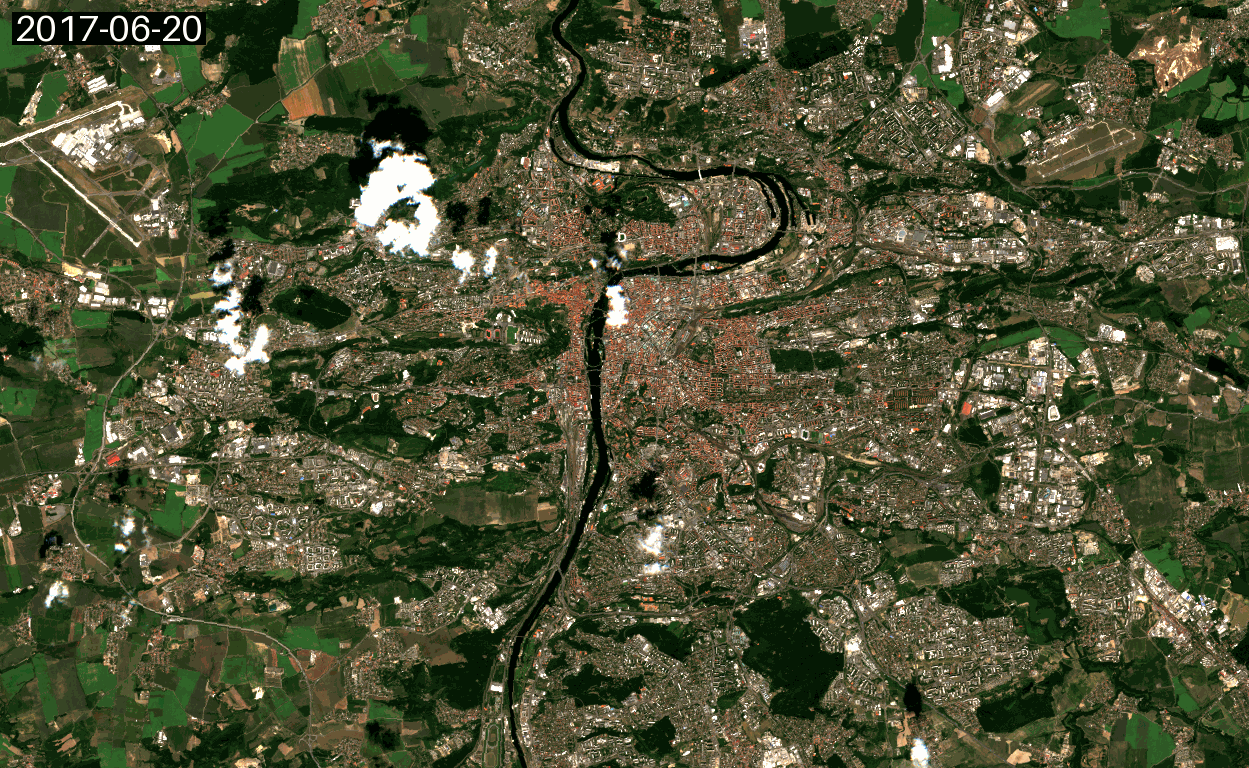

In [14]:
gif = geogif.dgif(rgb, fps=1).compute()
gif

## Displaying Cloud Cover for Results

We extract the eo:cloud_cover values for each item and display them. The previously used sortby extension allows for automatic sorting of the results based on the selected parameter, in this case, cloud cover.

In [17]:
cloud_cover_values = [item['properties']['eo:cloud_cover'] for item in items]
cloud_cover_values

[0.03, 4.47, 7.65, 8.6]

## NDVI

The Normalized Difference Vegetation Index (`NDVI`) is a standardized indicator of the condition and quantity of green vegetation. It is based on the difference between the near-infrared (NIR) and red bands, which respond differently to vegetation. NDVI values range from `-1` to `1`. Higher values of the index correspond to higher reflectance in the infrared range, which indicates areas covered by vegetation.

In this example, we will calculate NDVI for a selected period (Summer 2017) in Prague to visualize vegetation health.

First, ensure all required packages are installed and imported.

In [44]:
!pip install numpy && pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

Select NIR (B08_10m) and Red (B04_10m) bands. There's no need for resampling since the data is already in a 10m resolution. Otherwise, you would need to resample the lower-resolution band to match the higher-resolution band, typically using interpolation methods.

In [45]:
nir = stack.sel(band="B08_10m")
red = stack.sel(band="B04_10m")

Now, with the selected bands, we can proceed to calculate the NDVI according to the following formula:

$$
NDVI = \frac{NIR - RED}{NIR + RED}
$$

Where:
- `NIR` is the Near-Infrared band (B08).
- `RED` is the Red band (B04).

In [ ]:
ndvi = (nir - red) / (nir + red)

Finally, we can visualize the results on a plot.

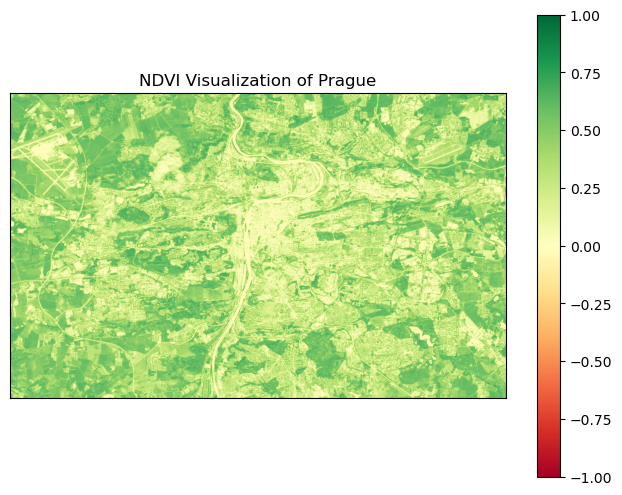

In [50]:
ndvi_single_layer = ndvi.isel(time=0)
plt.figure(figsize=(8, 6))
plt.imshow(ndvi_single_layer, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title("NDVI Visualization of Prague")
plt.xticks([])
plt.yticks([])
plt.show()

The resulting NDVI image confirms our expectations and provides a clear view of the land cover in Prague. Urbanized areas, such as the city center, correspond to lower NDVI values around 0.2, reflecting the presence of built-up land, roads, and infrastructure. These areas show minimal vegetation. In contrast, regions with dense vegetation, like parks and forests, exhibit higher NDVI values, typically ranging between 0.4 and 0.6, indicating healthy, green vegetation. Additionally, agricultural fields surrounding Prague are characterized by NDVI values closer to 1, highlighting areas with lush, well-maintained crops. This visual representation clearly distinguishes between urban, natural, and agricultural areas based on the NDVI index. The river areas, on the other hand, are marked by low NDVI values, corresponding to the presence of water.